In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive")
os.chdir("/content/drive/MyDrive/DP")

Mounted at /content/drive


In [ ]:
import nibabel as nib
from scipy import ndimage
import re
import numpy as np
import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import torchvision.models as models
from tensorflow import keras
from keras.utils import *
from keras.layers import *
from keras.models import Sequential
import scipy
import scipy.ndimage.interpolation as interpolation
import cv2
from sklearn.model_selection import train_test_split
import random
import itertools

In [ ]:
def read_patient_info_data(path):
  patient_info = {}
  with open(os.path.join(path, 'Info.cfg')) as f_in:
    for line in f_in:
      l = line.rstrip().split(": ")
      patient_info[l[0]] = l[1]
  return patient_info

def read_nifti_file(filepath , type):
    """Read and load volume"""
    patient_info = read_patient_info_data(filepath)
    patient_name = os.path.basename(filepath)
    patient_No = int(re.match("patient(\d{3})", patient_name).group(1))
    if type == "ED" :
      ED_frame_No = int(patient_info['ED'])
      ed_img = "patient%03d_frame%02d.nii.gz" %(patient_No, ED_frame_No)
      ED = nib.load(os.path.join(filepath , ed_img))
      scan = ED.get_fdata()


    if type == "ES" :
      ES_frame_No = int(patient_info['ES'])
      es_img = "patient%03d_frame%02d.nii.gz" %(patient_No, ES_frame_No)
      ES = nib.load(os.path.join(filepath , es_img))
      scan = ES.get_fdata()

    return scan

def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 8
    desired_width =128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path , type):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path , type)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)

    return volume


## Test on one data


In [ ]:
path = "/content/drive/MyDrive/DP/Patient_Groups_test/HCM/patient021/patient021_frame01.nii.gz"
data = nib.load(path)
header = data.header
data = data.get_fdata()
data = normalize(data)
data = resize_volume(data)

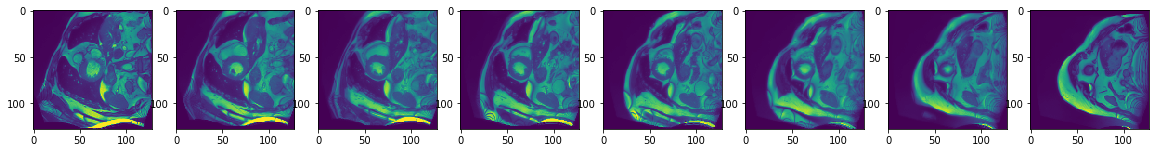

In [ ]:
def ShowSlicesAcrossAxis(data, axis, numberOfSlices, steps):
    if axis == 'x':
        plt.figure(figsize=(20, 20))
        for i in range(data.shape[2]):
            plt.subplot(1,data.shape[2],i+1)
            plt.imshow(data[:,:,i], interpolation='none' )
        plt.show()
# ShowSlicesAcrossAxis(data_rot, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_shift, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_scale, "x" , 10 , 1)
ShowSlicesAcrossAxis(data, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_gau, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_ela, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_off, "x" , 10 , 1)

## Loading data

In [ ]:
training = "/content/drive/MyDrive/DP/dataset2/train_set/"
path_to_training = [os.path.join(training , x) for x in sorted(next(os.walk(training))[1])]
validation = "/content/drive/MyDrive/DP/dataset2/validation_set/"
path_to_validation = [os.path.join(validation , x) for x in sorted(next(os.walk(validation))[1])]
test = "/content/drive/MyDrive/DP/dataset2/test_set/"
path_to_test = [os.path.join(test , x) for x in sorted(next(os.walk(test))[1])]
len(path_to_training) , len(path_to_validation) , len(path_to_test)

(70, 15, 15)

In [ ]:
label = {'NOR':0, 'MINF':1, 'DCM':2, 'HCM':3, 'RV':4 }
train_es_label = np.array([label[read_patient_info_data(x)["Group"]] for x in path_to_training])
validation_es_label = np.array([label[read_patient_info_data(x)["Group"]] for x in path_to_validation])
test_es_label = np.array([label[read_patient_info_data(x)["Group"]] for x in path_to_test])

In [ ]:
# train_ed_data = np.array([process_scan(path , "ED") for path in path_to_training])
# validation_ed_data = np.array([process_scan(path , "ED") for path in path_to_validation])
train_es_data = np.array([process_scan(path , "ES") for path in path_to_training])
validation_es_data = np.array([process_scan(path , "ES") for path in path_to_validation])
test_es_data = np.array([process_scan(path , "ES") for path in path_to_test])

In [ ]:
print("training model data shape is" , train_es_data.shape)
print("validation model data shape is" , validation_es_data.shape)
print("test model data shape is" , test_es_data.shape)

training model data shape is (70, 128, 128, 8)
validation model data shape is (15, 128, 128, 8)
test model data shape is (15, 128, 128, 8)


In [ ]:
# random.seed(1)
# split =  [random.sample(range(17*i , 17*i+17),3) for i in range(0,5)]
# split = list(itertools.chain.from_iterable(split))
# remain = list(set(range(85)) - set(split))
# validation_es = train_es_data[split]
# validation_label = train_es_label[split]
# train_es = train_es_data[remain]
# train_label = train_es_label[remain]

## Augumentation

In [ ]:
!pip install dltk

In [ ]:
import random
from scipy import ndimage
from dltk.io.augmentation import *

def rotate(volume):
    """Rotate the volume by a few degrees"""
    def scipy_rotate(volume):
        # define some rotation angles
        # angles = int(np.random.randint(-5,5, size=2))
        # # pick angles at random
        angle = int(np.random.uniform(-10,10))
        # rotate volume
        volume = scipy.ndimage.rotate(volume, angle, reshape=False , order = 0 , mode = "nearest")
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume


    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def shift(volume):
  offset = list(np.random.randint(-5,5, size=2))
  if [int(offset[0]),int(offset[1])] == [0,0]:
    return shift(volume)
  volume = scipy.ndimage.interpolation.shift(volume , (int(offset[0]), int(offset[1]), 0), order=0 , mode='nearest')
  volume[volume < 0] = 0
  volume[volume > 1] = 1
  return volume

def scaleit(volume):
  factor = float(np.around(np.random.uniform(0.9, 1.1, size=1), 2))

  height, width, depth= volume.shape
  zheight             = int(np.round(factor * height))
  zwidth              = int(np.round(factor * width))
  zdepth              = depth

  if factor < 1.0:
    newimg  = np.copy(volume)
    row     = (height - zheight) // 2
    col     = (width - zwidth) // 2
    layer   = (depth - zdepth) // 2
    newimg[row:row+zheight, col:col+zwidth, layer:layer+zdepth] = scipy.ndimage.interpolation.zoom(volume, (float(factor), float(factor), 1.0), order=5, mode='nearest')[0:zheight, 0:zwidth, 0:zdepth]

    return newimg

  elif factor > 1.0:
    row     = (zheight - height) // 2
    col     = (zwidth - width) // 2
    layer   = (zdepth - depth) // 2

    newimg = scipy.ndimage.interpolation.zoom(volume[row:row+zheight, col:col+zwidth, layer:layer+zdepth], (float(factor), float(factor), 1.0), order=0, mode='nearest')

    extrah = (newimg.shape[0] - height) // 2
    extraw = (newimg.shape[1] - width) // 2
    extrad = (newimg.shape[2] - depth) // 2
    newimg = newimg[extrah:extrah+height, extraw:extraw+width, extrad:extrad+depth]

    return newimg

  else:
    return scaleit(volume)

def gaussian_noise(volume):
  std = float(np.around(np.random.uniform(0.01, 0.02, size=1), 2))
  noise = np.random.normal(0 , std , volume.shape[:2])
  noise = np.stack([noise for _ in range(volume.shape[2])] , axis = 2 )

  newimg = volume + noise
  newimg = np.clip(newimg , 0, 1)
  return newimg

def elastic(volume):
  v = np.copy(volume)
  newimg = elastic_transform(v , alpha=[5, 5, 0], sigma=[1, 1, 0])
  return newimg

def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    out = np.copy(input_img)

    while True:
        s = np.random.uniform(0.01, 0.02) * img_h * img_w
        r = np.random.uniform(0.4, 0.5)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    c =  0.71428573
    out[top:top + h, left:left + w, :] = c

    return out

def contrast(volume):
  out = np.copy(volume)
  alpha = int(np.random.uniform(15,30))
  adjusted = cv2.convertScaleAbs(volume, alpha = alpha, beta=20)
  adjusted = adjusted/adjusted.max()
  return adjusted

In [ ]:
data_rot = rotate(data)
data_shift = shift(data)
data_scale = scaleit(data)
data_gau = gaussian_noise(data)
data_ela = elastic(data)
data_off = eraser(data)
data_bright = contrast(data)

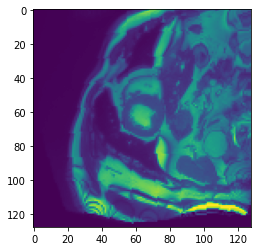

In [ ]:
plt.imshow(data_rot[:,:,3])
plt.savefig('rotate.png')
# ShowSlicesAcrossAxis(data_shift, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_scale, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_gau, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_ela, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_off, "x" , 10 , 1)
# ShowSlicesAcrossAxis(data_bright, "x" , 10 , 1)

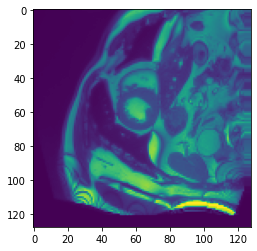

In [ ]:
plt.imshow(data_shift[:,:,3])
plt.savefig('shift.png')

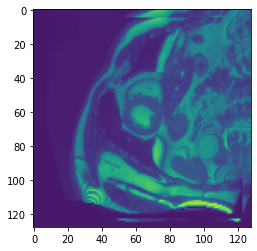

In [ ]:
plt.imshow(data_scale[:,:,3])
plt.savefig('scale.png')

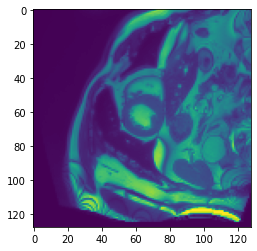

In [ ]:
plt.imshow(data[:,:,3])
plt.savefig('original.png')

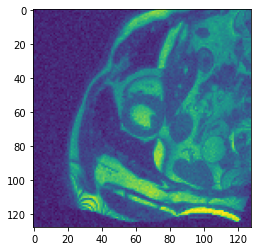

In [ ]:
plt.imshow(data_gau[:,:,3])
plt.savefig('gaussian.png')

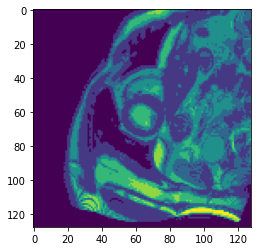

In [ ]:
plt.imshow(data_bright[:,:,3])
plt.savefig('contrast.png')

In [ ]:
train_rot = np.array([rotate(train_es_data[i]) for i in range(0,train_es_data.shape[0])])
train_shift = np.array([shift(train_es_data[i]) for i in range(0,train_es_data.shape[0])])
train_scale = np.array([scaleit(train_es_data[i]) for i in range(0,train_es_data.shape[0])])
train_gau = np.array([gaussian_noise(train_es_data[i]) for i in range(0,train_es_data.shape[0])])
# train_ela = np.array([elastic(train_es_data[i]) for i in range(0,train_es_data.shape[0])])
# train_era = np.array([eraser(train_es_data[i]) for i in range(0,train_es_data.shape[0])])
train_con = np.array([eraser(train_es_data[i]) for i in range(0,train_es_data.shape[0])])

In [ ]:
train_data = np.concatenate((train_es_data , train_rot , train_shift ,  train_scale  , train_con , train_gau) , axis = 0)
training_label = np.concatenate((train_es_label , train_es_label , train_es_label , train_es_label, train_es_label, train_es_label))

In [ ]:
print("training model data shape is" , train_data.shape)
print("training label shape is" , training_label.shape)

training model data shape is (420, 128, 128, 8)
training label shape is (420,)


In [ ]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    volume = tf.transpose(volume , perm = [2,0,1])
    volume = tf.stack([volume , volume , volume] , axis = 3)
    # volume = tf.expand_dims(volume , axis = 3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.transpose(volume , perm = [2,0,1])
    volume = tf.stack([volume , volume , volume] , axis = 3)
    # volume = tf.expand_dims(volume , axis = 3)
    return volume, label

In [ ]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((train_data, training_label))
validation_loader = tf.data.Dataset.from_tensor_slices((validation_es_data, validation_es_label))

batch_size = 8
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(train_es_data))
    .map(train_preprocessing ,  num_parallel_calls=100)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(validation_es_data))
    .map(validation_preprocessing )
    .batch(batch_size)
    .prefetch(2)
)

## 3D Model for Classification

## Model 1: ResNet18

In [ ]:
!pip install git+https://github.com/JihongJu/keras-resnet3d.git
!pip install classification-models-3D

  Cloning https://github.com/JihongJu/keras-resnet3d.git to /tmp/pip-req-build-w19ewjvv
  Running command git clone -q https://github.com/JihongJu/keras-resnet3d.git /tmp/pip-req-build-w19ewjvv
  Running command git submodule update --init --recursive -q
  Created wheel for keras-resnet3d: filename=keras_resnet3d-0.0.1-py3-none-any.whl size=4765 sha256=58ae82bccb76283e87e2de25d864f6fa1261759a6adcb478ee89e12ccc14ab07
  Stored in directory: /tmp/pip-ephem-wheel-cache-m88s0v0h/wheels/7e/d8/d8/79a8e9fdfacb40c998db593c423f1dd764cd65ceb66246d6f1
Successfully built keras-resnet3d
     |████████████████████████████████| 62 kB 1.2 MB/s 


In [ ]:
!pip install keras-applications
!pip install focal-loss

     |████████████████████████████████| 50 kB 3.2 MB/s 
     |████████████████████████████████| 462 kB 5.1 MB/s 


In [ ]:
from classification_models_3D.tfkeras import Classifiers
import tensorflow as tf
from focal_loss import SparseCategoricalFocalLoss
from keras import regularizers

In [ ]:
ResNet18, preprocess_input = Classifiers.get('resnet18')
base_model = ResNet18(
   input_shape=(8, 128, 128, 3),
   classes = 5,
   weights = 'imagenet'
)

regularizer = tf.keras.regularizers.l2(0.0005)
for layer in base_model.layers:
  for attr in ['kernel regularizer']:
    if hasattr(layer, attr):
      setattr(layer, attr, regularizer)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling3D())
model.add(Dropout(0.3))
model.add(Dense(5,'softmax'))

train_steps = 10000
lr_fn = tf.optimizers.schedules.CosineDecay(2e-6, decay_steps = train_steps)
opt = tf.optimizers.Adam(lr_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification_resnet18_051901.h5" , mode = "max" , monitor="val_accuracy" , save_best_only = True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)

model.compile(optimizer= opt,
              loss = SparseCategoricalFocalLoss(gamma=3),
              metrics=["accuracy"])

# model.compile(optimizer= opt,
#               loss = "sparse_categorical_crossentropy",
#               metrics=["accuracy"])

In [ ]:
# model.load_weights("3d_image_classification_resnet18_0516.h5")
model.fit(train_dataset ,
          validation_data = validation_dataset ,
          epochs = 80,
          callbacks = [checkpoint_cb],
          shuffle = True)

Epoch 1/80
53/53 [==============================] - 10s 141ms/step - loss: 1.7935 - accuracy: 0.2310 - val_loss: 1.6364 - val_accuracy: 0.2000
Epoch 2/80
53/53 [==============================] - 5s 96ms/step - loss: 1.4522 - accuracy: 0.2905 - val_loss: 1.3670 - val_accuracy: 0.2000
Epoch 3/80
53/53 [==============================] - 5s 99ms/step - loss: 1.1063 - accuracy: 0.3690 - val_loss: 1.2442 - val_accuracy: 0.2000
Epoch 4/80
53/53 [==============================] - 5s 96ms/step - loss: 0.8833 - accuracy: 0.4310 - val_loss: 1.0899 - val_accuracy: 0.2000
Epoch 5/80
53/53 [==============================] - 5s 95ms/step - loss: 0.8186 - accuracy: 0.4881 - val_loss: 0.9251 - val_accuracy: 0.2000
Epoch 6/80
53/53 [==============================] - 5s 96ms/step - loss: 0.7335 - accuracy: 0.5119 - val_loss: 0.8757 - val_accuracy: 0.2000
Epoch 7/80
53/53 [==============================] - 5s 96ms/step - loss: 0.6208 - accuracy: 0.5548 - val_loss: 0.9079 - val_accuracy: 0.2000
Epoch 8/80


In [ ]:
model.evaluate(validation_dataset)

2/2 [==============================] - 0s 30ms/step - loss: 1.0104 - accuracy: 0.5333


[1.0103751420974731, 0.5333333611488342]

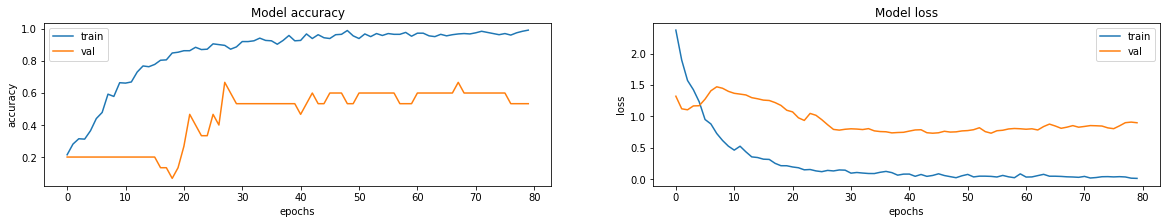

In [ ]:
# model.load_weights('3d_image_classification_resnet18_051601.h5')
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy" , "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

# plt.savefig('final.png')

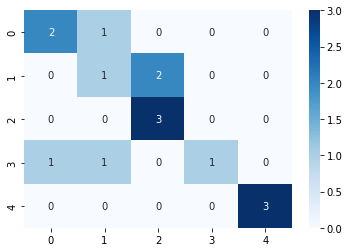

In [ ]:
from sklearn.metrics import confusion_matrix
model.load_weights("3d_image_classification_resnet18_0519.h5")
validation = tf.transpose(validation_es_data , perm = [0, 3, 1, 2])
validation = tf.stack([validation , validation , validation] , axis = 4)
predict = model.predict(validation)
y_pred = np.argmax(predict, axis=1)
cm = confusion_matrix(validation_es_label , y_pred)
import seaborn as sns
sns.heatmap(cm , annot=True, cmap="Blues")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(validation_es_label, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.33      0.33      0.33         3
           2       0.60      1.00      0.75         3
           3       1.00      0.33      0.50         3
           4       1.00      1.00      1.00         3

    accuracy                           0.67        15
   macro avg       0.72      0.67      0.65        15
weighted avg       0.72      0.67      0.65        15



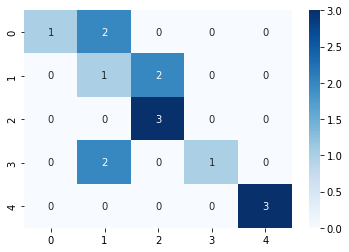

In [ ]:
import pandas as pd
model.load_weights("3d_image_classification_resnet18_0519.h5")
test = tf.transpose(test_es_data , perm = [0, 3, 1, 2])
test = tf.stack([test , test , test] , axis = 4)
test_pred = np.argmax(model.predict(test) , axis = 1)
pd.crosstab(test_es_label, test_pred, rownames=['label'],colnames=['predict'])
cm_test = confusion_matrix(test_es_label , test_pred)
sns.heatmap(cm_test , annot=True, cmap="Blues")

In [ ]:
print(classification_report(test_es_label, test_pred))

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.20      0.33      0.25         3
           2       0.60      1.00      0.75         3
           3       1.00      0.33      0.50         3
           4       1.00      1.00      1.00         3

    accuracy                           0.60        15
   macro avg       0.76      0.60      0.60        15
weighted avg       0.76      0.60      0.60        15



## Model 2: Keras Model

In [ ]:
!pip install focal-loss

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from focal_loss import SparseCategoricalFocalLoss

In [ ]:
train_data = np.concatenate((train_es_data , train_rot , train_shift ,  train_scale  , train_con , train_gau) , axis = 0)
training_label = np.concatenate((train_es_label , train_es_label , train_es_label , train_es_label, train_es_label, train_es_label))

In [ ]:
def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    # volume = rotate(volume)
    # volume = tf.transpose(volume , perm = [2,0,1])
    # volume = tf.stack([volume , volume , volume] , axis = 3)
    volume = tf.expand_dims(volume , axis = 3)
    return volume, label

def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    # volume = tf.transpose(volume , perm = [2,0,1])
    # volume = tf.stack([volume , volume , volume] , axis = 3)
    volume = tf.expand_dims(volume , axis = 3)
    return volume, label

# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((train_data, training_label))
validation_loader = tf.data.Dataset.from_tensor_slices((validation_es_data, validation_es_label))

batch_size = 16
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(train_es_data))
    .map(train_preprocessing ,  num_parallel_calls=100)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(validation_es_data))
    .map(validation_preprocessing )
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
from tensorflow.python.ops.gen_math_ops import xdivy_eager_fallback
def get_model(width=128, height=128, depth=8):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth ,1))

    x = layers.Conv3D(filters=64, kernel_size=(3,3,3) , strides = (3,3,3), kernel_regularizer = regularizers.L2(5e-4) , padding = "same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha = 1.0)(x)
    x = layers.MaxPool3D(pool_size= (3, 3, 3) , strides = (2,2,2) , padding = "same")(x)

    x = layers.Conv3D(filters=128, kernel_size= (3,3,3), kernel_regularizer = regularizers.L2(5e-4) , padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha = 1)(x)
    x = layers.MaxPool3D(pool_size=(3, 3, 3), strides = (2,2,2) , padding = "same")(x)

    x = layers.Conv3D(filters=256, kernel_size=(3,3,3) , kernel_regularizer = regularizers.L2(5e-4) , padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha = 1)(x)
    x = layers.MaxPool3D(pool_size=(3, 3, 3), strides = (2,2,2) , padding = "same")(x)

    x = layers.Conv3D(filters=512, kernel_size=(3,3,3) , kernel_regularizer = regularizers.L2(5e-4) , padding = 'same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha = 1)(x)
    x = layers.MaxPool3D(pool_size=(3, 3, 3) , strides = (2, 2, 2) , padding = "same")(x)

    x = layers.Conv3D(filters=64, kernel_size=(3,3,3) , kernel_regularizer = regularizers.L2(5e-4) , padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ELU(alpha = 1)(x)
    x = layers.MaxPool3D(pool_size=(3, 3, 3) , strides = (2, 2, 2) , padding = "same")(x)


    x = layers.Dense(units=100, kernel_regularizer = regularizers.L2(5e-4))(x)
    x = layers.Dense(units=50, kernel_regularizer = regularizers.L2(5e-4))(x)
    x = layers.Dense(units=5, kernel_regularizer = regularizers.L2(5e-4))(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Softmax(axis = -1)(x)
    x = layers.GlobalAveragePooling3D()(x)
    # x = layers.Flatten()(x)

    outputs = layers.Dense(units=5,kernel_regularizer = regularizers.L2(5e-4))(x)
    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=8)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 8, 1)]  0         
                                                                 
 conv3d_5 (Conv3D)           (None, 43, 43, 3, 64)     1792      
                                                                 
 batch_normalization_5 (Batc  (None, 43, 43, 3, 64)    256       
 hNormalization)                                                 
                                                                 
 elu_5 (ELU)                 (None, 43, 43, 3, 64)     0         
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 22, 22, 2, 64)    0         
 3D)                                                             
                                                                 
 conv3d_6 (Conv3D)           (None, 22, 22, 2, 128)    221312

In [ ]:
train_steps = 10000
lr_fn = tf.optimizers.schedules.CosineDecay(1e-6, decay_steps = train_steps)
opt = tf.optimizers.Adam(lr_fn)


model.compile(optimizer= opt,
              loss = SparseCategoricalFocalLoss(gamma=2),
              metrics=["accuracy"])

In [ ]:
model.fit(train_dataset ,
          validation_data = validation_dataset ,
          epochs = 100,
          shuffle = True)

Epoch 1/100
32/32 [==============================] - 1s 29ms/step - loss: 2.5539 - accuracy: 0.2941 - val_loss: 3.3239 - val_accuracy: 0.4667
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 2.6184 - accuracy: 0.3255 - val_loss: 3.9478 - val_accuracy: 0.5333
Epoch 3/100
32/32 [==============================] - 1s 29ms/step - loss: 2.5519 - accuracy: 0.3235 - val_loss: 3.9434 - val_accuracy: 0.4667
Epoch 4/100
32/32 [==============================] - 1s 27ms/step - loss: 2.4876 - accuracy: 0.3118 - val_loss: 3.9482 - val_accuracy: 0.5333
Epoch 5/100
32/32 [==============================] - 1s 28ms/step - loss: 2.5588 - accuracy: 0.3176 - val_loss: 3.9588 - val_accuracy: 0.5333
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 2.5057 - accuracy: 0.3216 - val_loss: 3.9668 - val_accuracy: 0.5333
Epoch 7/100
32/32 [==============================] - 1s 27ms/step - loss: 2.4284 - accuracy: 0.3137 - val_loss: 3.9973 - val_accuracy: 0.5333
Epoch 

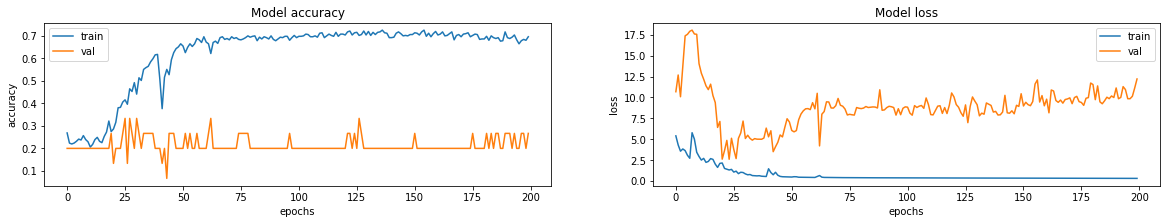

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["accuracy" , "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(validation_dataset), axis= -1)
import pandas as pd
pd.crosstab(validation_es_label, y_pred,rownames=['label'],colnames=['predict'])

predict,0,3,4
label,,,
0,2,0,1
1,1,0,2
2,2,0,1
3,0,2,1
4,1,0,2
